## Import Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from itables import show
from sklearn.preprocessing import StandardScaler

from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Create figure directory
import os
if not os.path.exists('eda_figures'):
    os.makedirs('eda_figures')

## Load Data

In [ ]:
df_final_sampled = pd.read_csv('./data/final_sampled_v2.csv',sep=';')
df_final_daily = pd.read_csv('./data/final_daily_v2.csv',sep=';')
df_daily_nutrition_summary = pd.read_csv('./data/daily_nutrition_summary.csv',sep=';')
df_user_cluster = pd.read_csv('./data/user_cluster_final.csv',sep=';')


## Data Quality Assessment


=== DATA QUALITY ASSESSMENT ===

Columns with missing values:
                              Column  Missing_Count  Missing_Percentage
sleep                          sleep         208396              98.458
mood                            mood          71638              33.846
department                department           1114               0.526
Extraversion            Extraversion           1114               0.526
Agreeableness          Agreeableness           1114               0.526
Conscientiousness  Conscientiousness           1114               0.526
Neuroticism              Neuroticism           1114               0.526
Openness                    Openness           1114               0.526


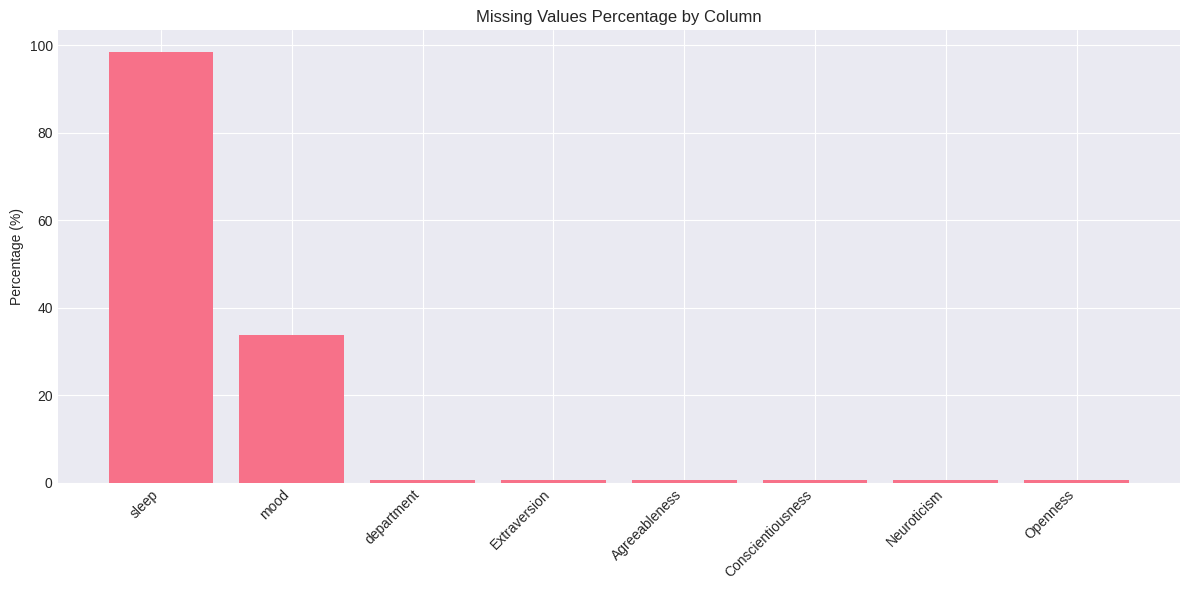


Duplicate rows: 0

Unique students: 190
Date range: 2020-11-12 19:00:00 to 2020-12-11 18:00:00


In [51]:
print("\n=== DATA QUALITY ASSESSMENT ===")

# Missing values analysis
missing_df = pd.DataFrame({
    'Column': df_final_sampled.columns,
    'Missing_Count': df_final_sampled.isnull().sum(),
    'Missing_Percentage': (df_final_sampled.isnull().sum() / len(df_final_sampled)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_df) > 0:
    print("\nColumns with missing values:")
    print(missing_df)
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    plt.bar(missing_df['Column'], missing_df['Missing_Percentage'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Missing Values Percentage by Column')
    plt.ylabel('Percentage (%)')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found!")

# Check for duplicates
print(f"\nDuplicate rows: {df_final_sampled.duplicated().sum()}")

# Data consistency checks
print(f"\nUnique students: {df_final_sampled['id'].nunique()}")
print(f"Date range: {df_final_sampled['social_date'].min()} to {df_final_sampled['social_date'].max()}")

## Demographic Analysis


 PERSONALITY TRAITS ANALYSIS


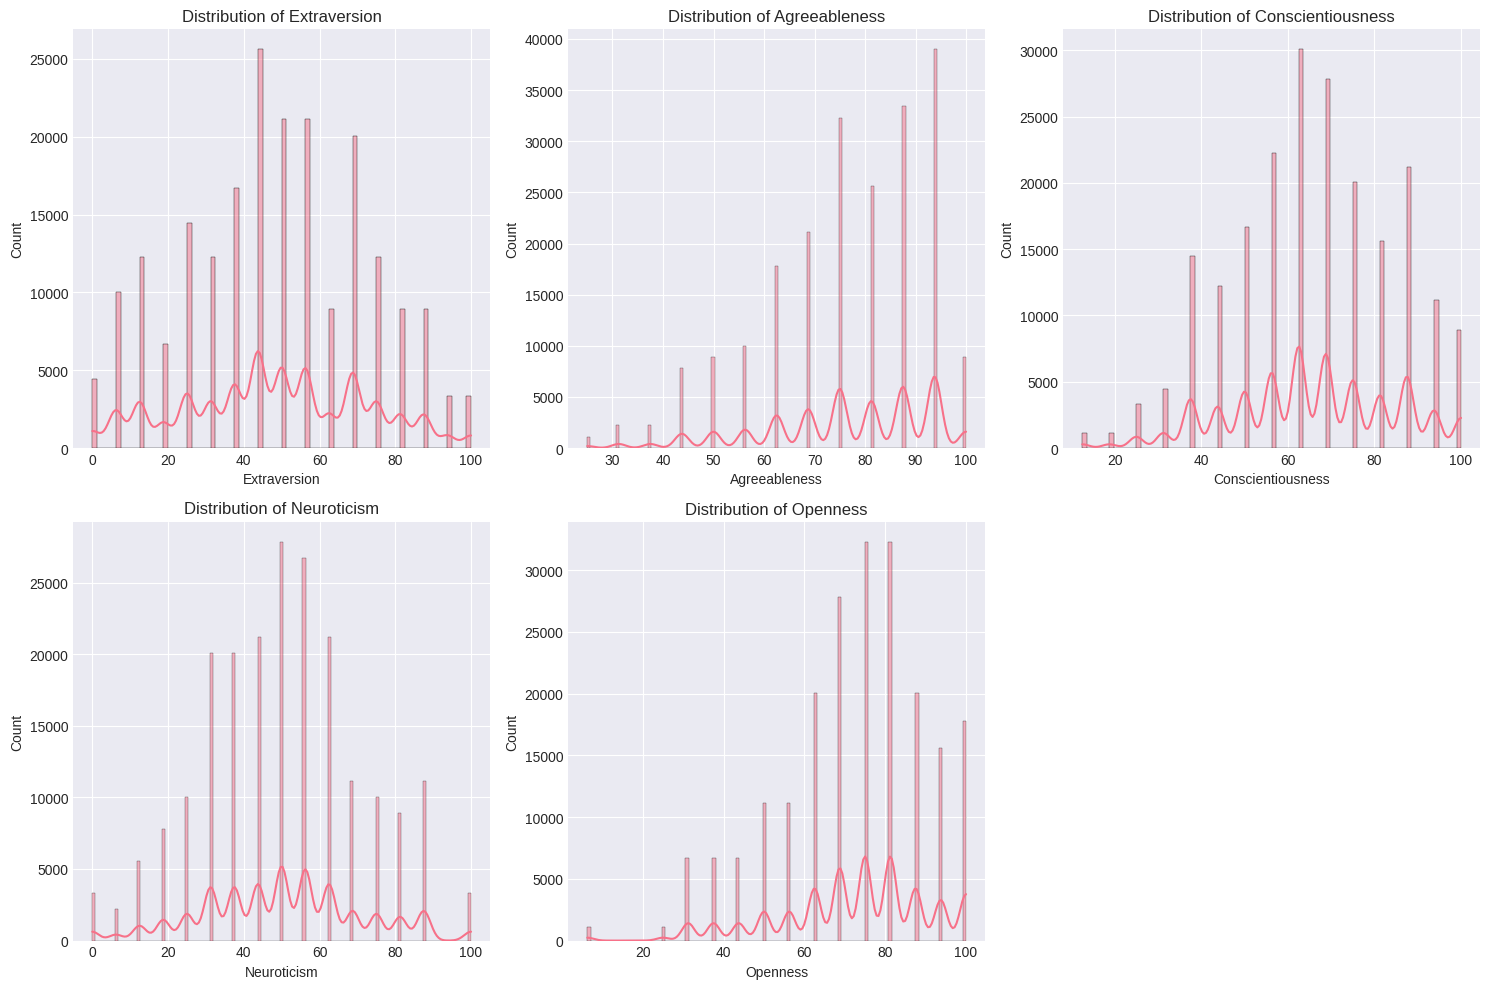

In [66]:
print("\n PERSONALITY TRAITS ANALYSIS")
trait_cols = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']


plt.figure(figsize=(15, 10))
for i, col in enumerate(trait_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_final_sampled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()



=== STUDENT DEMOGRAPHICS ===
Total unique students: 190


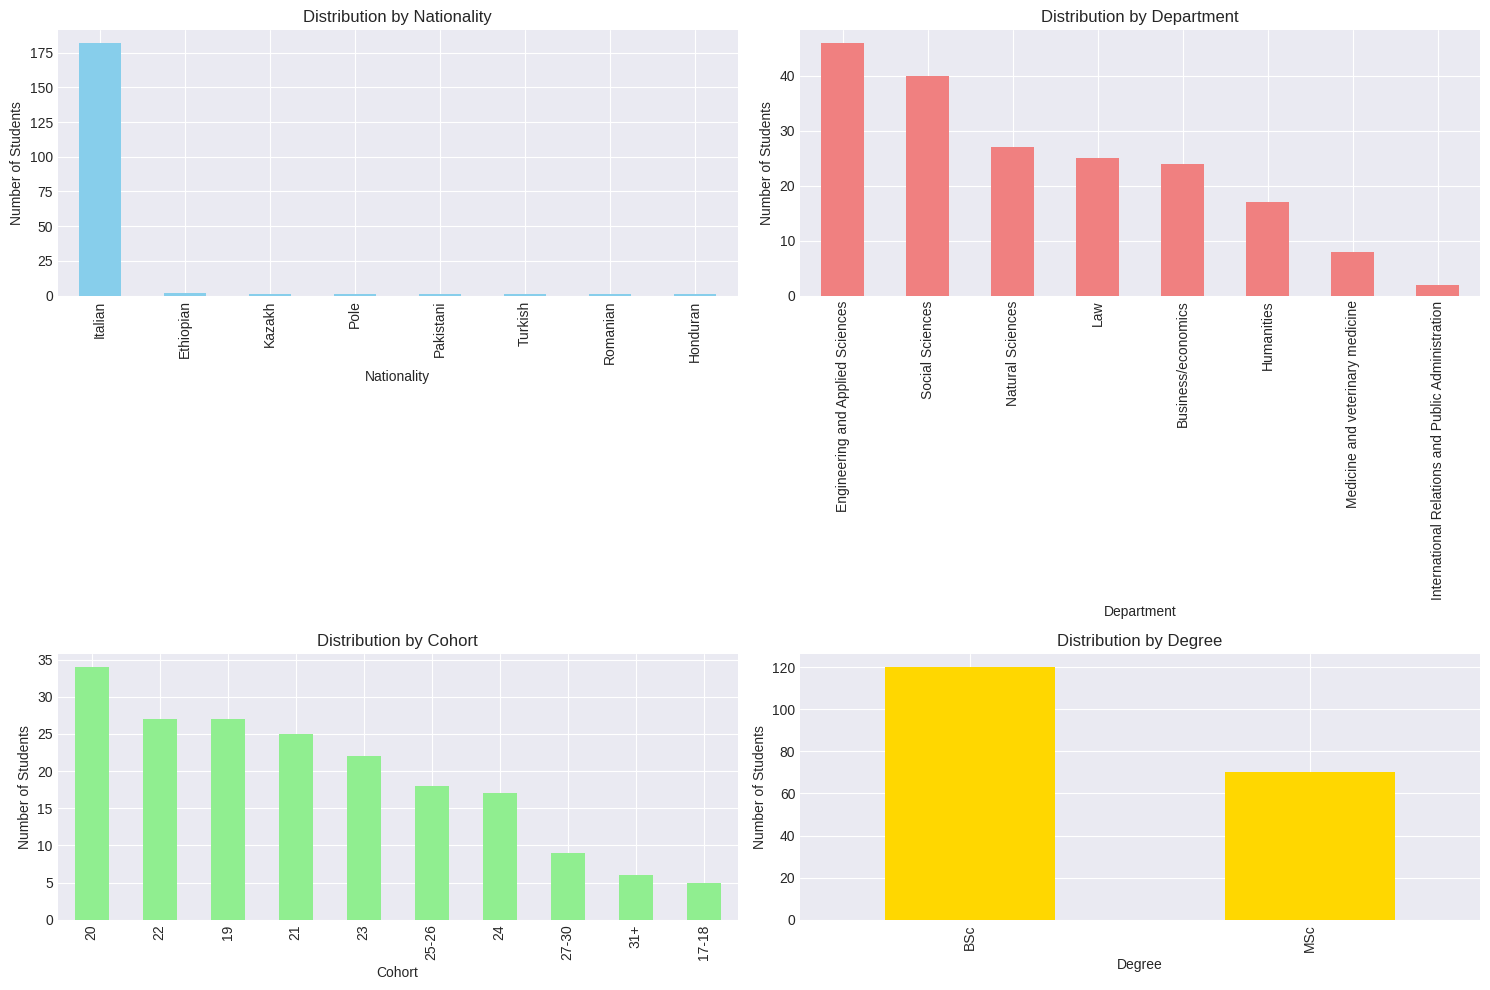

In [52]:
print("\n=== STUDENT DEMOGRAPHICS ===")

# Get unique student information
student_info = df_final_sampled.groupby('id').agg({
    'nationality': 'first',
    'department': 'first',
    'cohort': 'first',
    'degree': 'first',
    'Extraversion': 'first',
    'Agreeableness': 'first',
    'Conscientiousness': 'first',
    'Neuroticism': 'first',
    'Openness': 'first'
}).reset_index()

print(f"Total unique students: {len(student_info)}")

# Demographics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Nationality distribution
nationality_counts = student_info['nationality'].value_counts()
nationality_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Distribution by Nationality')
axes[0,0].set_xlabel('Nationality')
axes[0,0].set_ylabel('Number of Students')

# Department distribution
dept_counts = student_info['department'].value_counts()
dept_counts.plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Distribution by Department')
axes[0,1].set_xlabel('Department')
axes[0,1].set_ylabel('Number of Students')

# Cohort distribution
cohort_counts = student_info['cohort'].value_counts()
cohort_counts.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Distribution by Cohort')
axes[1,0].set_xlabel('Cohort')
axes[1,0].set_ylabel('Number of Students')

# Degree distribution
degree_counts = student_info['degree'].value_counts()
degree_counts.plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Distribution by Degree')
axes[1,1].set_xlabel('Degree')
axes[1,1].set_ylabel('Number of Students')

plt.tight_layout()
plt.show()

## Nutritional Data Analysis

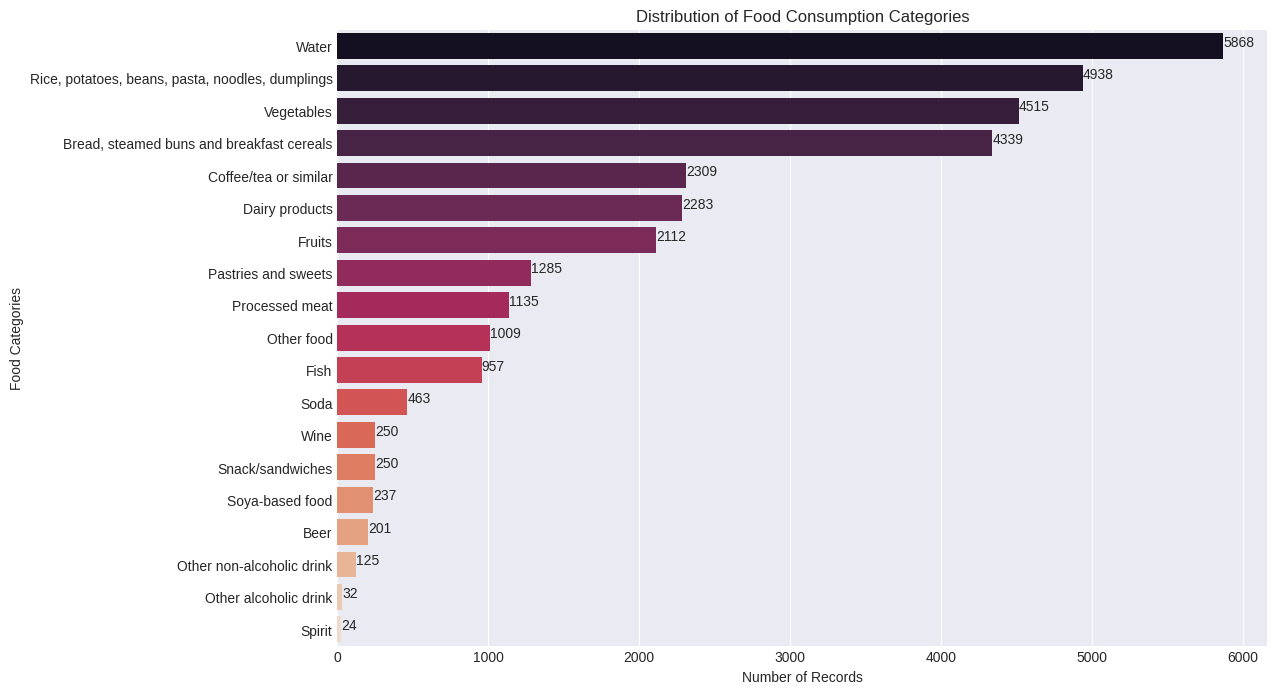

In [ ]:
df_td = pd.read_stata('./data/td_ita.dta')
df = pd.DataFrame(columns=['A3c'], data=df_td['A3c'].copy())


# Define food mapping based on the provided list
food_mapping = {
    1: 'Bread, steamed buns and breakfast cereals',
    2: 'Rice, potatoes, beans, pasta, noodles, dumplings',
    3: 'Vegetables',
    4: 'Fruits',
    5: 'Meat',
    6: 'Fish',
    7: 'Processed meat',
    8: 'Dairy products',
    9: 'Soya-based food',
    10: 'Pastries and sweets',
    11: 'Snack/sandwiches',
    12: 'Water',
    13: 'Soda',
    14: 'Coffee/tea or similar',
    15: 'Other non-alcoholic drink',
    16: 'Beer',
    17: 'Wine',
    18: 'Spirit',
    19: 'Other alcoholic drink',
    20: 'Other food'
}

# Replace '99' and 'Expired' with NaN
df['A3c'] = df['A3c'].replace(['99', 'Expired', ' ',''], np.nan)


# Ensure all values are split properly and explode them
df_expanded = df['A3c'].dropna().str.replace(' ', '').str.split(',').explode().astype(int)


# Map numeric values to food names
df_expanded = df_expanded.map(food_mapping)

# Combine counts including missing values
df_combined = df_expanded.value_counts()

# Plotting bar plot with values
plt.figure(figsize=(12, 8))
sns.barplot(x=df_combined.values, y=df_combined.index, palette='rocket')

# Adding values on the bars
for index, value in enumerate(df_combined.values):
    plt.text(value, index, str(value))

plt.xlabel('Number of Records')
plt.ylabel('Food Categories')
plt.title('Distribution of Food Consumption Categories')
plt.show()

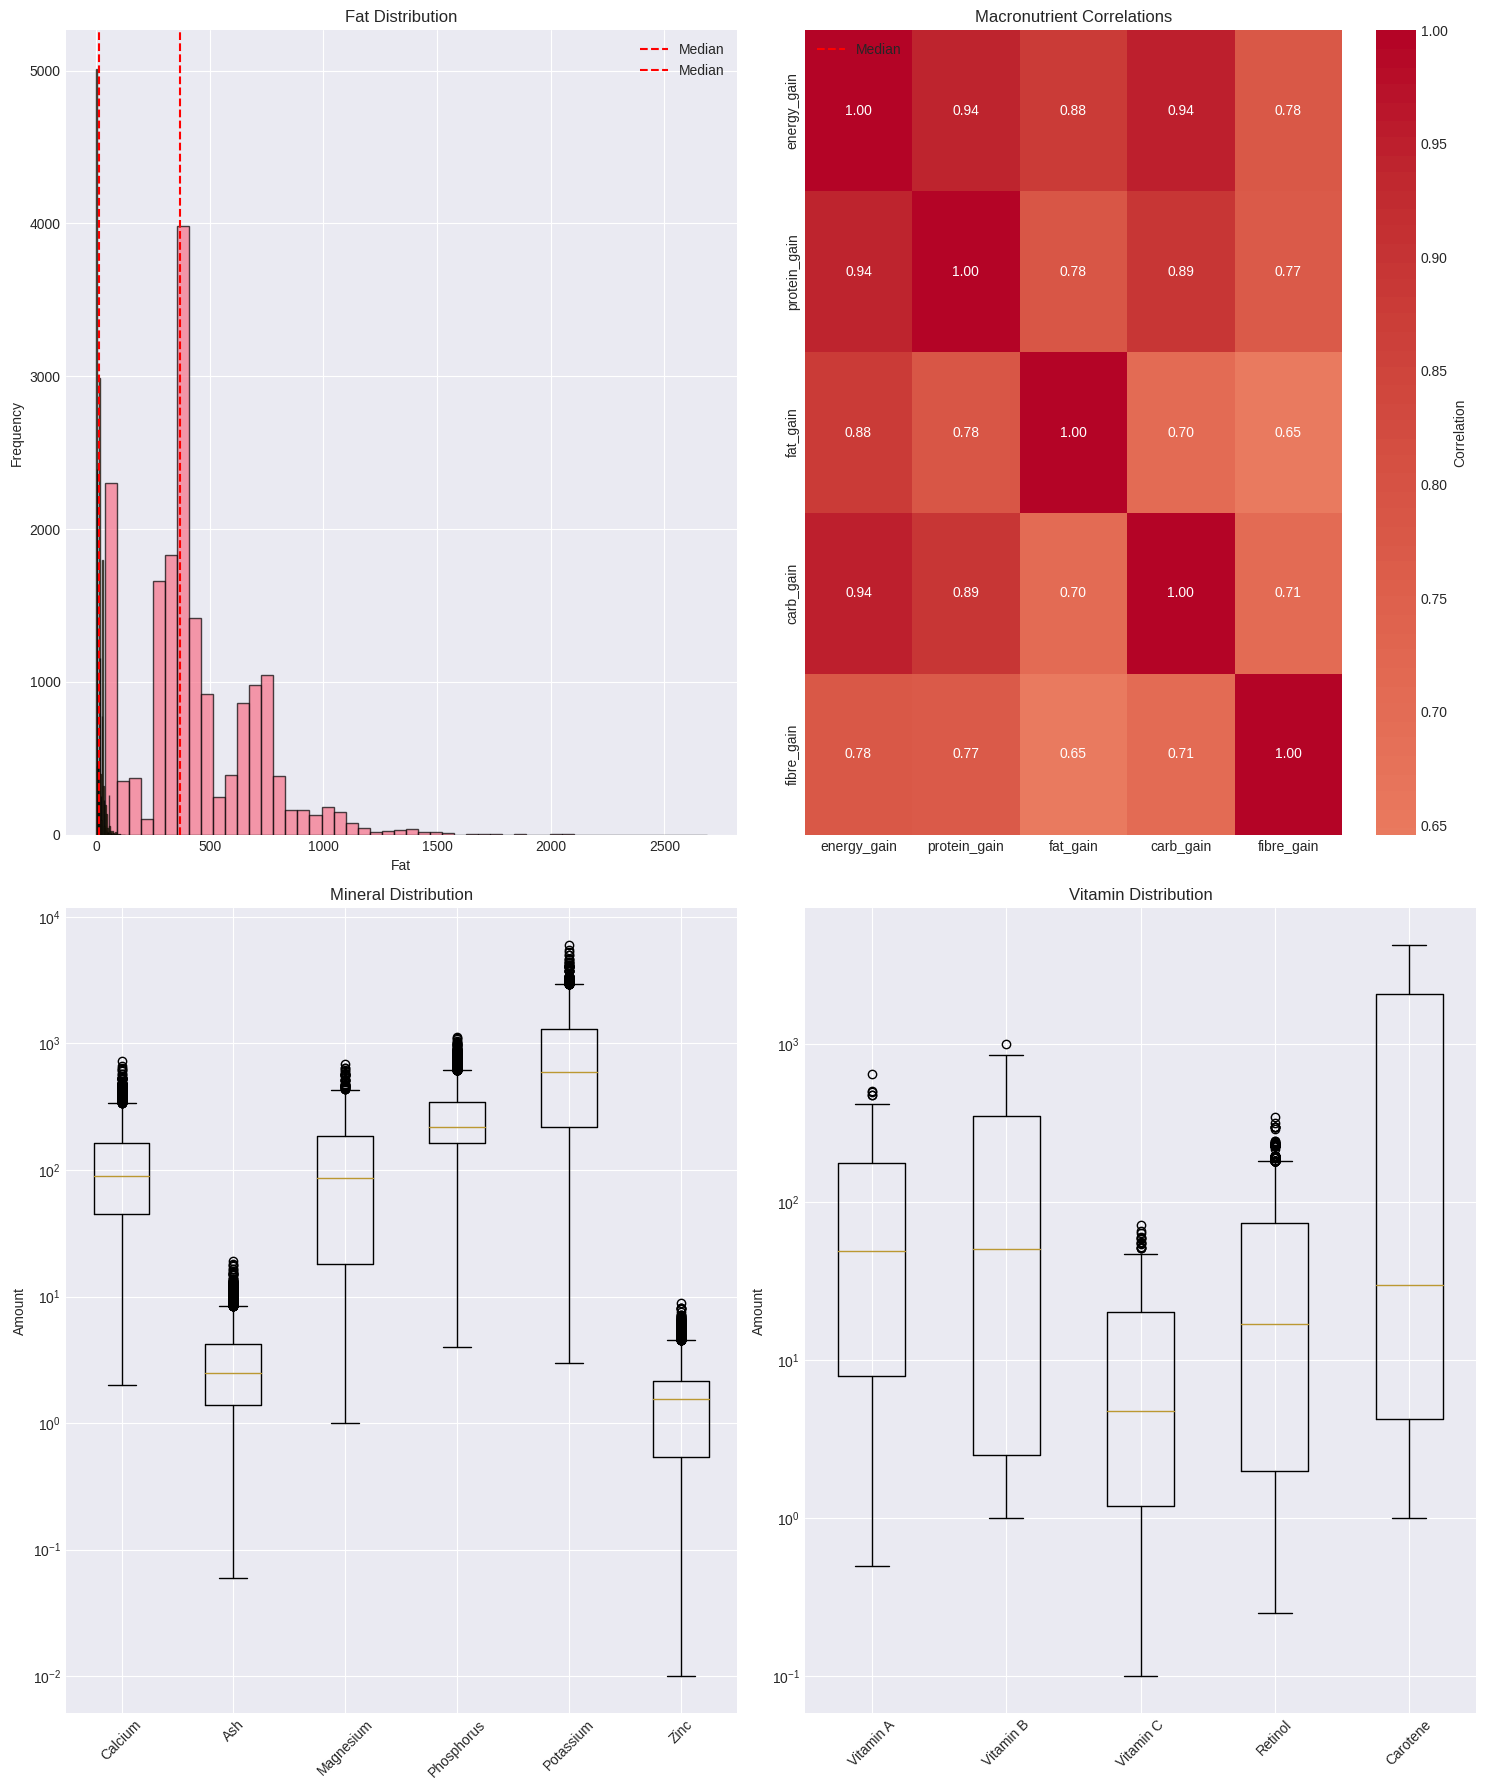


=== NUTRITIONAL SUMMARY STATISTICS ===
Macronutrients:
       energy_gain  protein_gain   fat_gain  carb_gain  fibre_gain
count   211660.000    211660.000 211660.000 211660.000  211660.000
mean        36.192         1.170      1.163      4.581       1.200
std        141.406         4.707      5.638     18.019       5.954
min          0.000         0.000      0.000      0.000       0.000
25%          0.000         0.000      0.000      0.000       0.000
50%          0.000         0.000      0.000      0.000       0.000
75%          0.000         0.000      0.000      0.000       0.000
max       2685.727        76.336    127.960    277.880      97.877

HEI Score Statistics:


In [ ]:
def analyze_nutrition(df):
    # Define nutrient groups
    
    macros = ['energy_gain', 'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain']
    minerals = ['calcium', 'ash', 'magnesium', 'phosphorus', 'potassium', 'zinc']
    vitamins = ['vitamin_A', 'vitamin_B', 'vitamin_C', 'retinol', 'carotene', 'thiamin', 'riboflavin']

    fig, axes = plt.subplots(2, 2, figsize=(15, 18))

    # Macronutrient distributions
    for i, macro in enumerate(macros[:3]):
        data = df[df[macro] > 0][macro]  # Filter out zeros
        axes[0, i if i < 2 else 0].hist(data, bins=50, alpha=0.7, edgecolor='black')
        axes[0, i if i < 2 else 0].set_xlabel(macro.replace('_gain', '').title())
        axes[0, i if i < 2 else 0].set_ylabel('Frequency')
        axes[0, i if i < 2 else 0].set_title(f'{macro.replace("_gain", "").title()} Distribution')
        axes[0, i if i < 2 else 0].axvline(data.median(), color='red', linestyle='--', label='Median')
        axes[0, i if i < 2 else 0].legend()
    
    # Macronutrient correlations
    macro_corr = df[macros].corr()
    sns.heatmap(macro_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                ax=axes[0, 1], cbar_kws={'label': 'Correlation'})
    axes[0, 1].set_title('Macronutrient Correlations')
    
    # Mineral distributions (box plots)
    mineral_data = df[minerals].apply(lambda x: x[x > 0])  # Filter zeros
    axes[1, 0].boxplot([mineral_data[col].dropna() for col in minerals], 
                       labels=[col.replace('_', ' ').title() for col in minerals])
    axes[1, 0].set_ylabel('Amount')
    axes[1, 0].set_title('Mineral Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_yscale('log')  # Log scale for better visualization
    
    # Vitamin distributions
    vitamin_data = df[vitamins].apply(lambda x: x[x > 0])
    axes[1, 1].boxplot([vitamin_data[col].dropna() for col in vitamins[:5]], 
                       labels=[col.replace('_', ' ').title() for col in vitamins[:5]])
    axes[1, 1].set_ylabel('Amount')
    axes[1, 1].set_title('Vitamin Distribution')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].set_yscale('log')
    
    
    plt.tight_layout()
    plt.savefig('eda_figures/nutrition_analysis.png')
    plt.show()
    
    # Summary statistics
    print("\n=== NUTRITIONAL SUMMARY STATISTICS ===")
    print("Macronutrients:")
    print(df[macros].describe())
    print("\nHEI Score Statistics:")

analyze_nutrition(df)


 NUTRITIONAL ANALYSIS


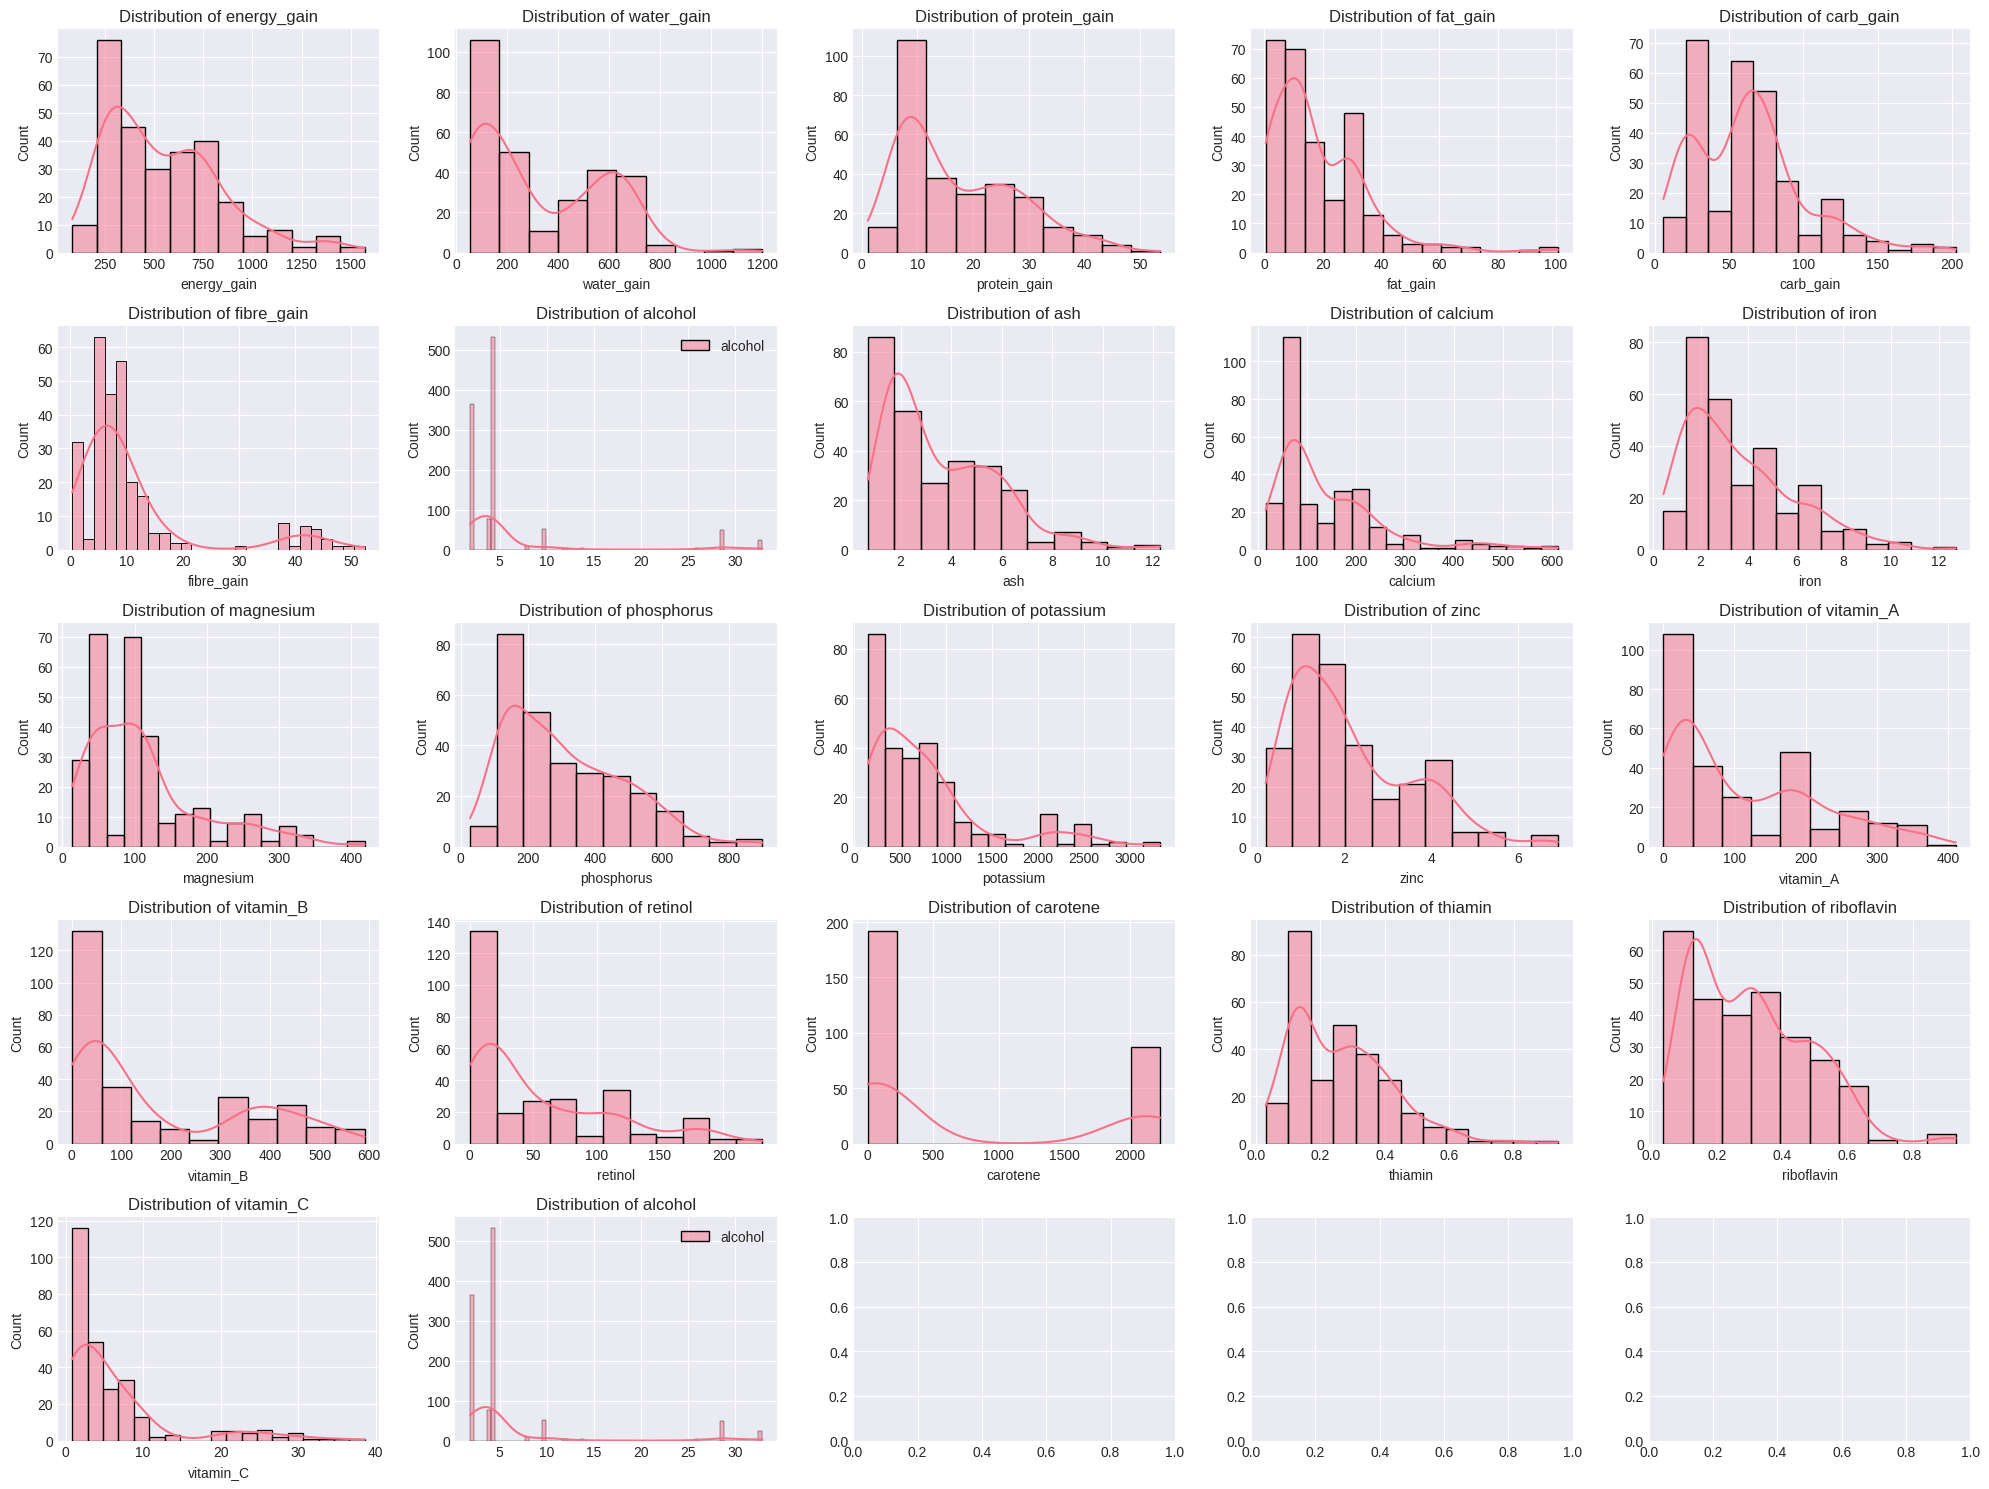

In [103]:
print("\n NUTRITIONAL ANALYSIS")
nutrient_cols = ['energy_gain', 'water_gain', 'protein_gain', 'fat_gain', 
                'carb_gain', 'fibre_gain', 'alcohol', 'ash', 'calcium',
                'iron', 'magnesium', 'phosphorus', 'potassium', 'zinc',
                'vitamin_A', 'vitamin_B', 'retinol', 'carotene', 'thiamin',
                'riboflavin', 'vitamin_C','alcohol']


df_nutrient = df_final_sampled[nutrient_cols].copy()
df_nutrient = df_nutrient[(df_nutrient.T != 0).all()]
# Distribution plots
fig, axes = plt.subplots(5, 5, figsize=(20, 15))
axes = axes.ravel()
for i, col in enumerate(nutrient_cols[:25]):
    sns.histplot(df_nutrient[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

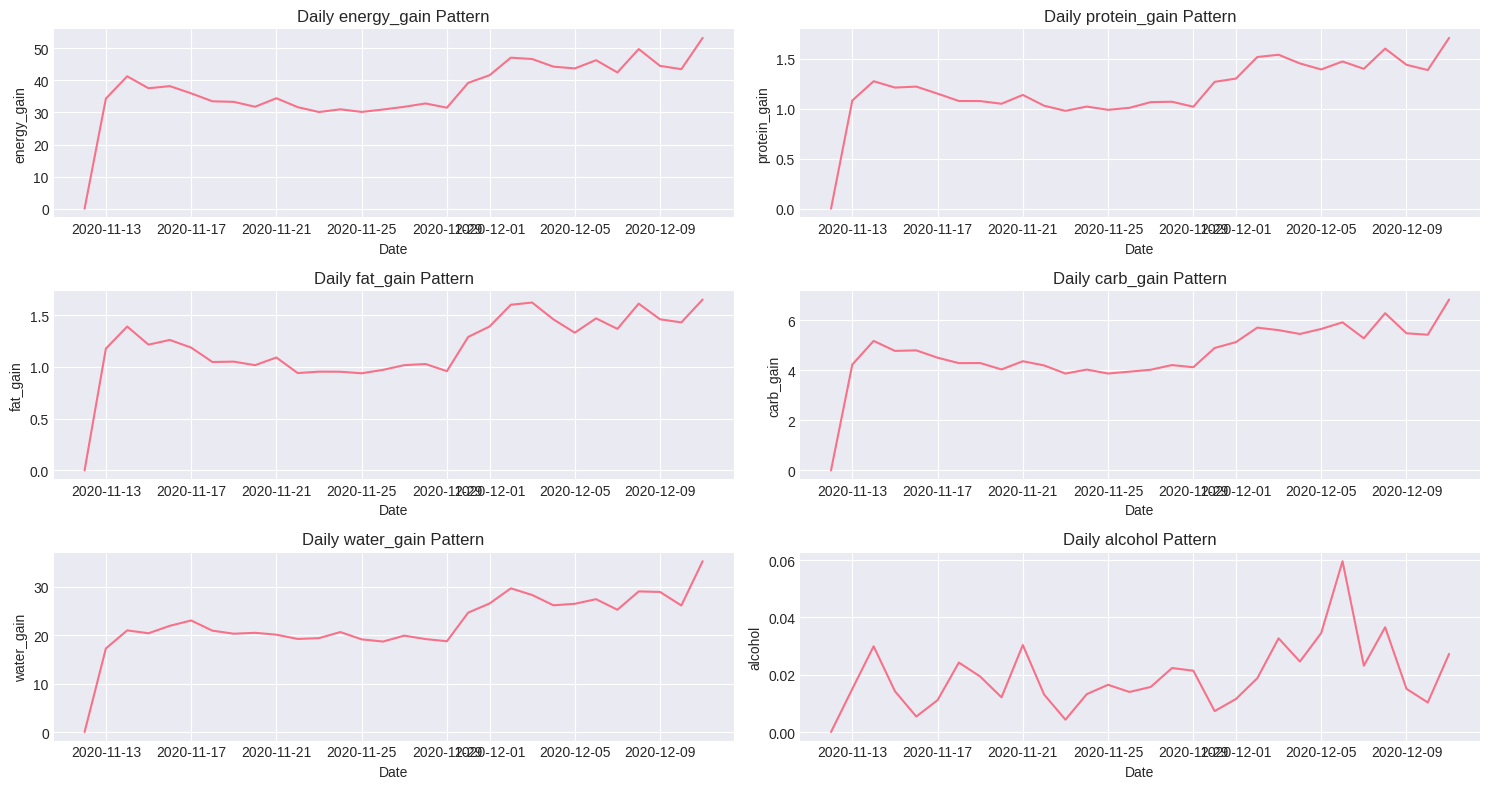

In [ ]:
daily_nutrients = df_final_sampled.set_index('social_date')[nutrient_cols].resample('D').mean()

plt.figure(figsize=(15, 8))
for i, col in enumerate(['energy_gain', 'protein_gain', 'fat_gain', 'carb_gain','water_gain','alcohol'], 1):
    plt.subplot(3, 2, i)
    plt.plot(daily_nutrients.index, daily_nutrients[col])
    plt.title(f'Daily {col} Pattern')
    plt.xlabel('Date')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

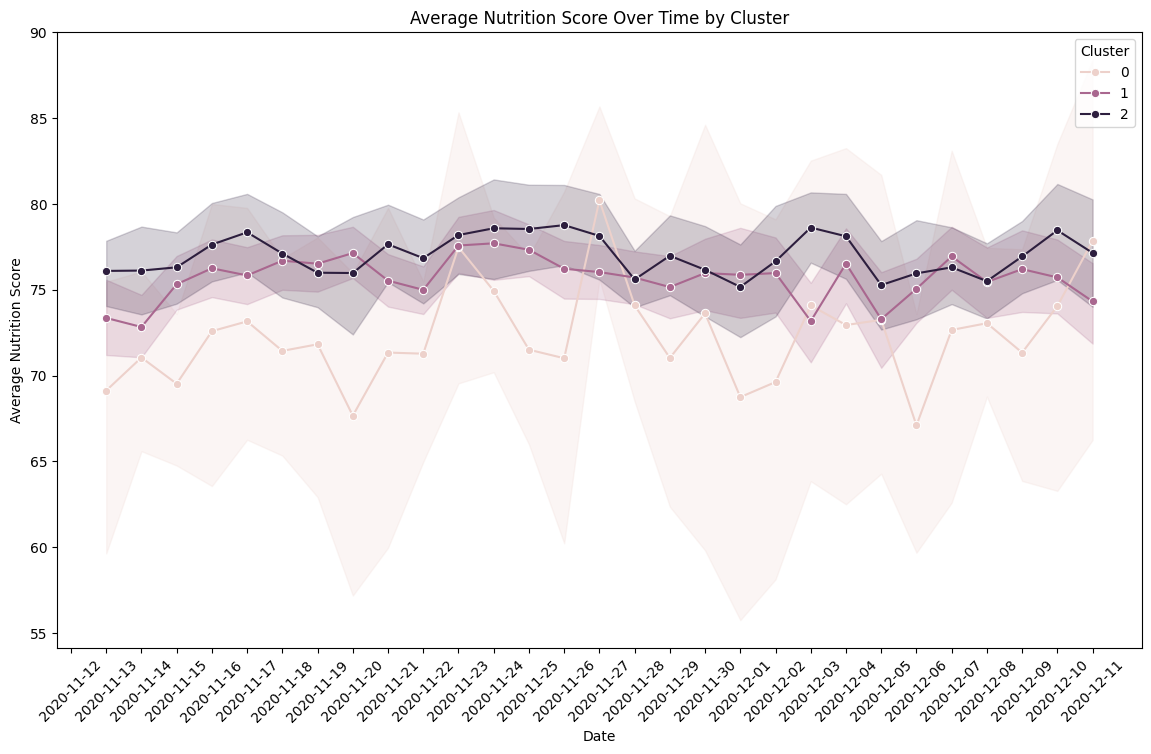

In [ ]:
df = df_user_cluster.merge(df_daily_nutrition_summary, on='id', how='inner')
# Set the plot size and style
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='social_date', y='NDS_daily', hue='kmeans_cluster', marker='o')

# Add titles and labels
plt.title("Average Nutrition Score Over Time by Cluster")
plt.xlabel("Date")
plt.ylabel("Average Nutrition Score")
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()


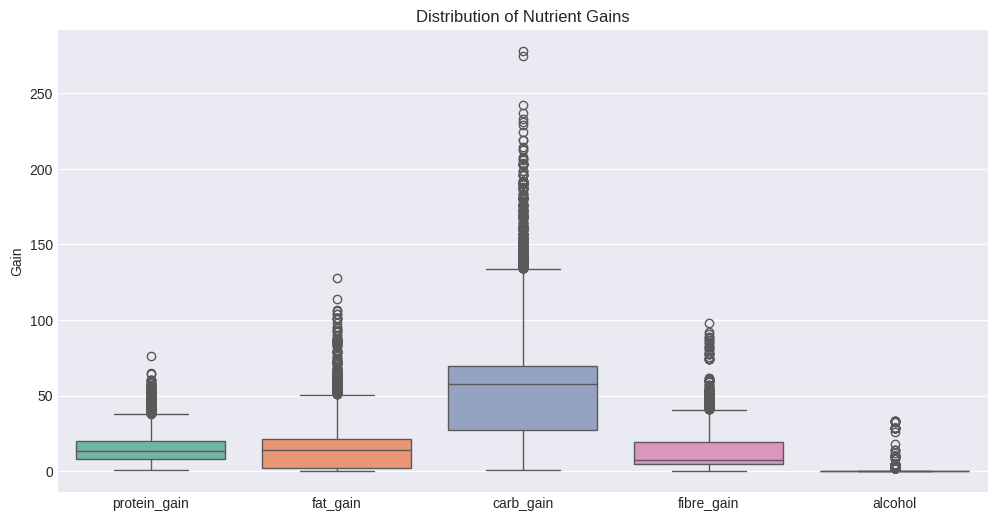

In [ ]:

# Boxplot for multiple nutrition-related columns
nutrition_columns = [ 'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain','alcohol',]

plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(df_final_sampled.query(' protein_gain >0 and fat_gain >0 and carb_gain >0 and fibre_gain>0')[nutrition_columns], columns=nutrition_columns), palette='Set2')
plt.title('Distribution of Nutrient Gains')
plt.ylabel('Gain')
plt.show()


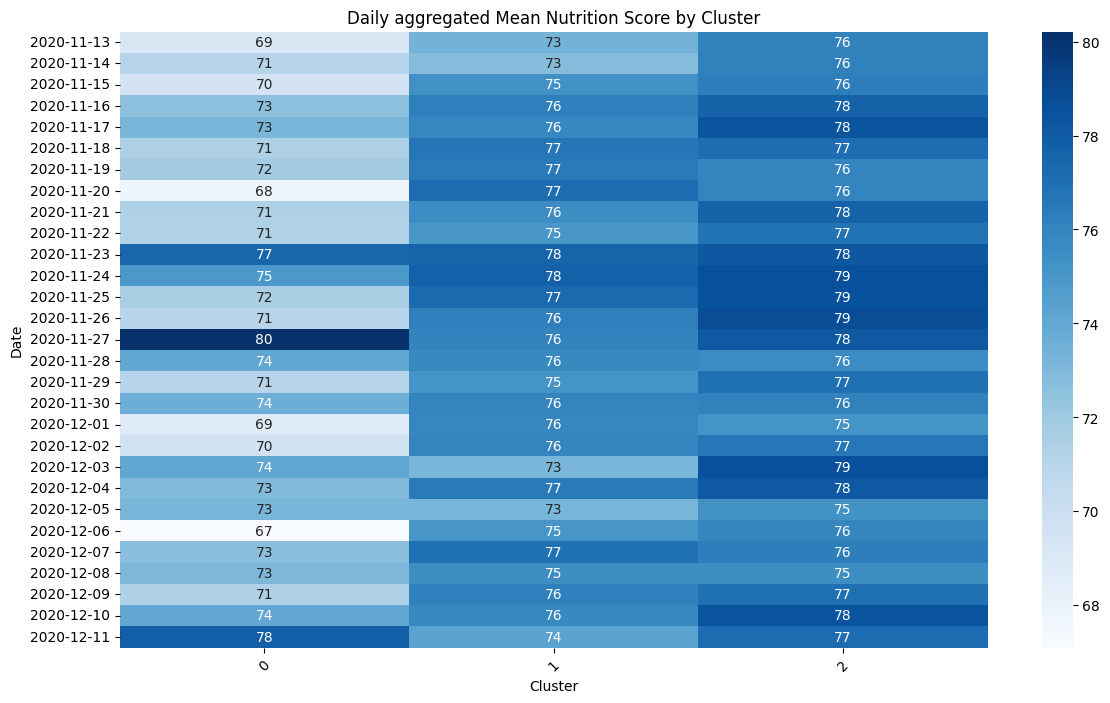

In [ ]:
# Pivot the data to prepare for heatmap visualization
time_series_heatmap_df = df.pivot_table(values='NDS_daily', index='social_date', columns='kmeans_cluster', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(time_series_heatmap_df, cmap="Blues", annot=True, fmt=".0f")
plt.title("Daily aggregated Mean Nutrition Score by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.show()


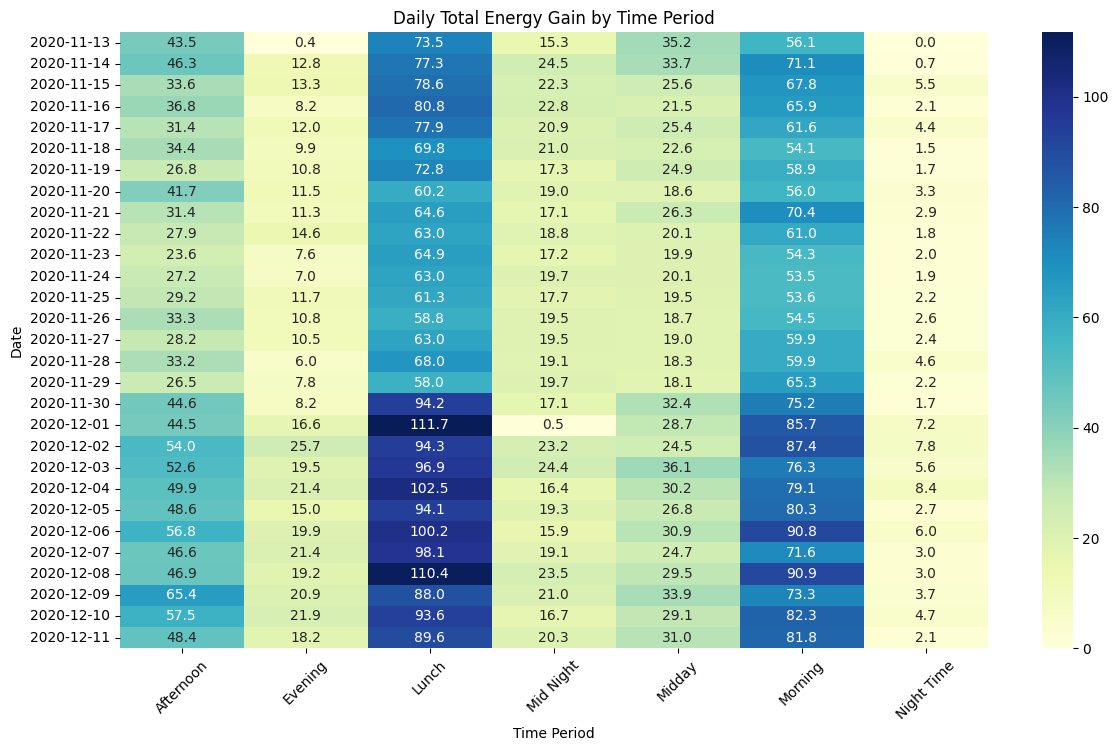

In [ ]:
# Pivot the data to use in a heatmap
heatmap_df = df_final_daily.pivot_table(values='energy_gain', index='date', columns='date_time', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Daily Total Energy Gain by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.show()


In [ ]:
df_final_daily.columns

Index(['id', 'date', 'date_time', 'energy_gain', 'water_gain', 'protein_gain',
       'fat_gain', 'carb_gain', 'fibre_gain', 'alcohol', 'ash', 'calcium',
       'iron', 'magnesium', 'phosphorus', 'potassium', 'zinc', 'vitamin_A',
       'vitamin_B', 'retinol', 'carotene', 'thiamin', 'riboflavin',
       'vitamin_C', 'sport_Walking, Trekking, and hiking',
       'sport_Jogging and running', 'sport_Cycling, skiing, and skating',
       'sport_Ball games', 'sport_Gymnastics and fitness',
       'sport_Water sports', 'sport_Other indoor activities',
       'sport_Other outdoor activities', 'mood', 'sleep', 'nationality',
       'department', 'cohort', 'degree', 'Extraversion', 'Agreeableness',
       'Conscientiousness', 'Neuroticism', 'Openness'],
      dtype='object')

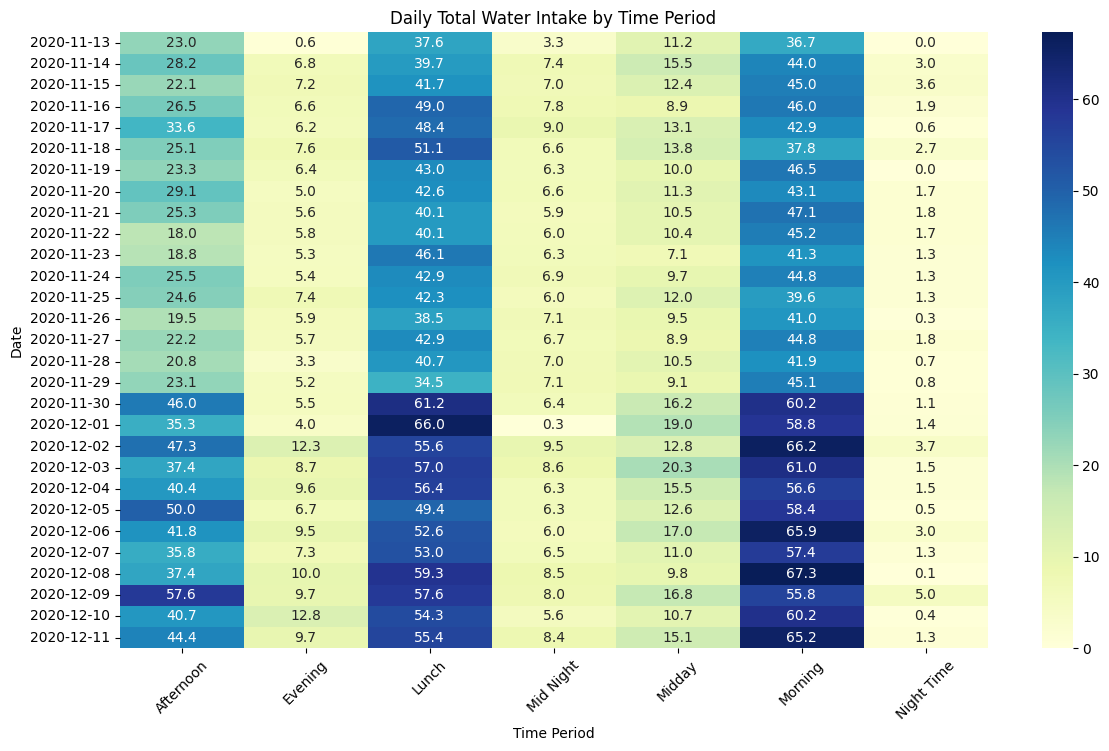

In [ ]:
# Pivot the data to use in a heatmap
heatmap_df = df_final_daily.pivot_table(values='water_gain', index='date', columns='date_time', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Daily Total Water Intake by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.show()


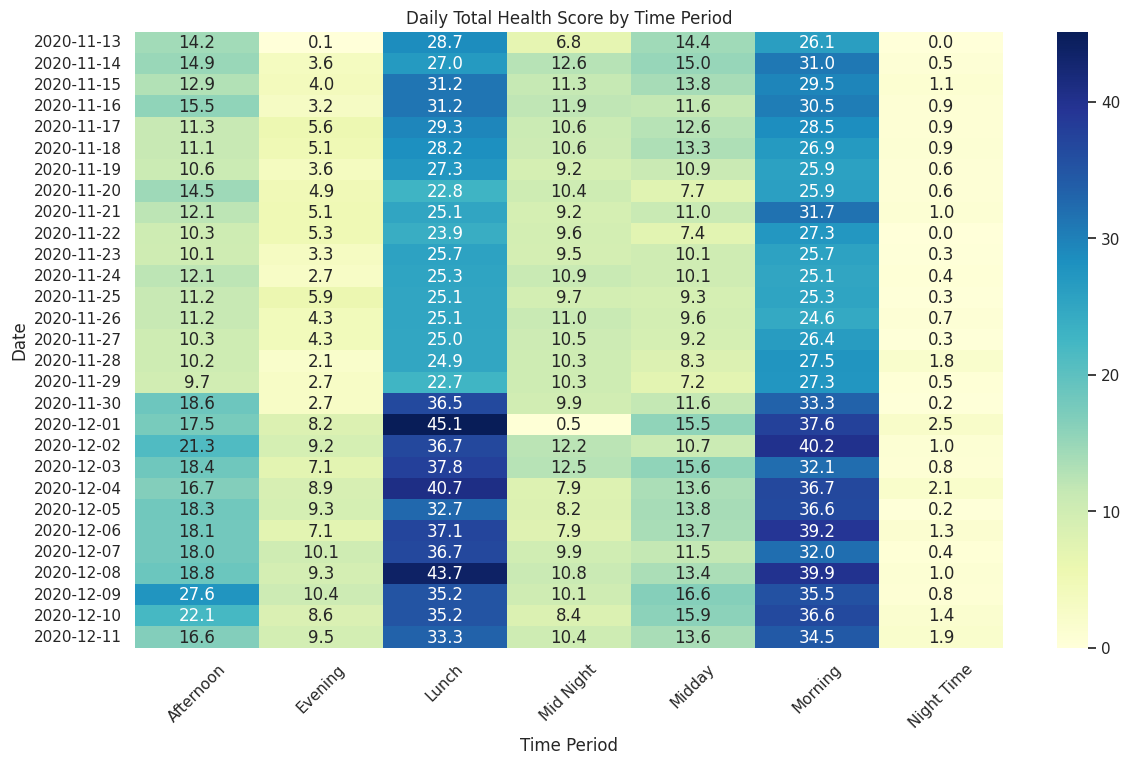

In [ ]:
# Pivot the data to use in a heatmap
heatmap_df = df_final_daily.pivot_table(values='HEI_Score', index='date', columns='date_time', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Daily Total Health Score by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.show()


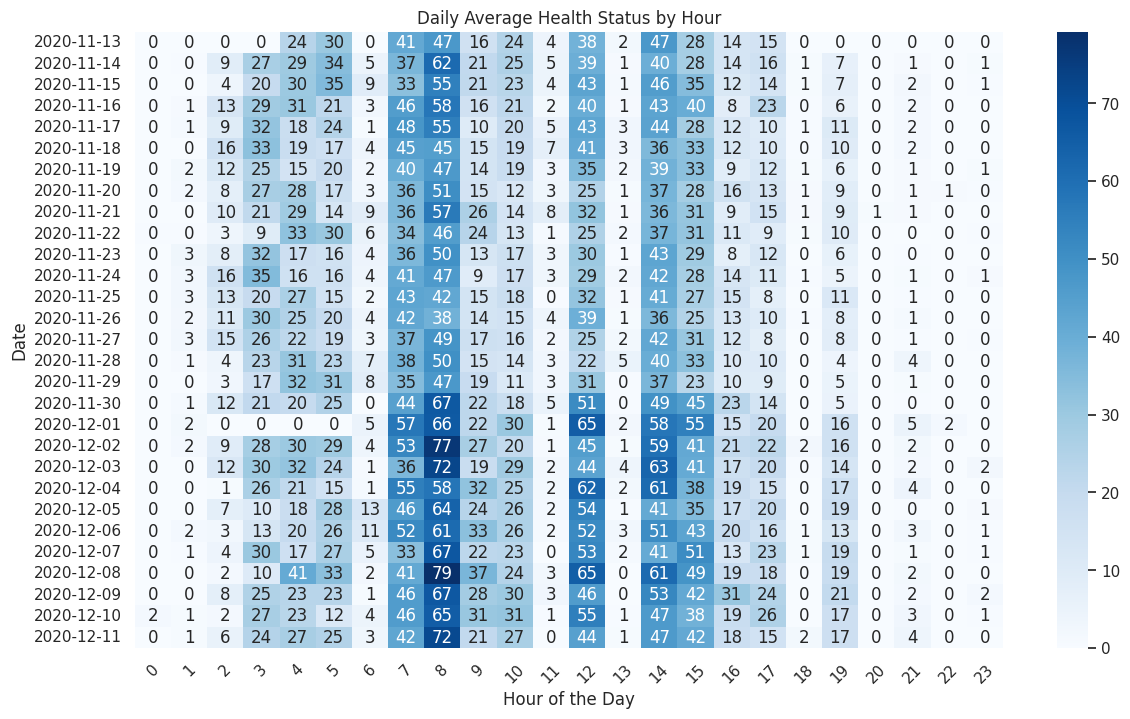

In [ ]:
# HEI_Score is currently not in df_final_daily 

# Pivot the data to prepare for heatmap visualization
time_series_heatmap_df = df_final_daily.pivot_table(values='HEI_Score', index='date', columns='hour', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(time_series_heatmap_df, cmap="Blues", annot=True, fmt=".0f")
plt.title("Daily Average Health Status by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.show()


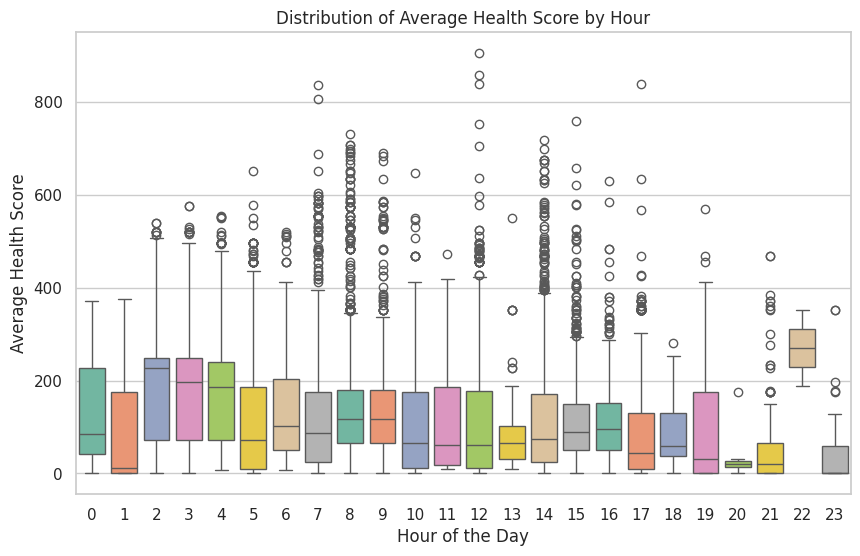

In [ ]:
# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final_daily.query('HEI_Score > 0'), x='hour', y='HEI_Score', palette="Set2")
plt.title("Distribution of Average Health Score by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Health Score")
plt.show()


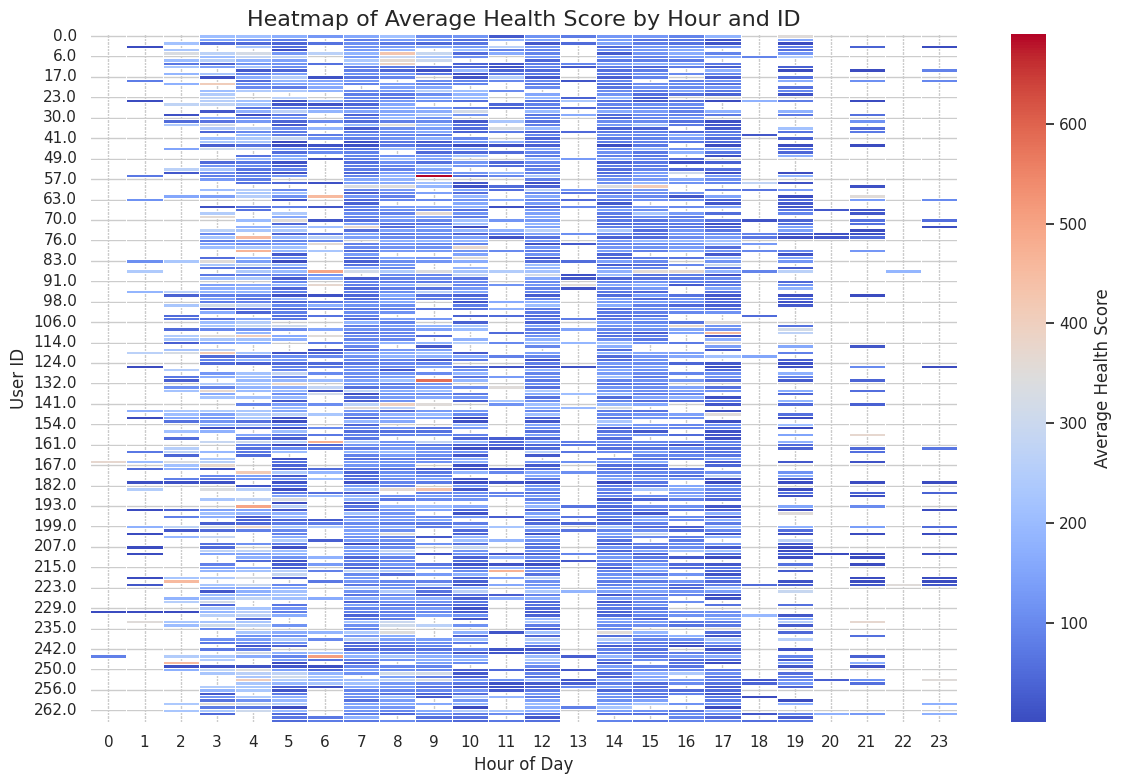

In [ ]:
agg_data = df_final_daily.query('HEI_Score>0').groupby(['id', 'hour'])['HEI_Score'].mean().reset_index()

# Pivot data for heatmap: 'id' as rows, 'hour' as columns
pivot_df = agg_data.pivot_table(index='id', columns='hour', values='HEI_Score', aggfunc='mean')

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='coolwarm', annot=False, cbar_kws={'label': 'Average Health Score'}, linewidths=0.5)
plt.title('Heatmap of Average Health Score by Hour and ID', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

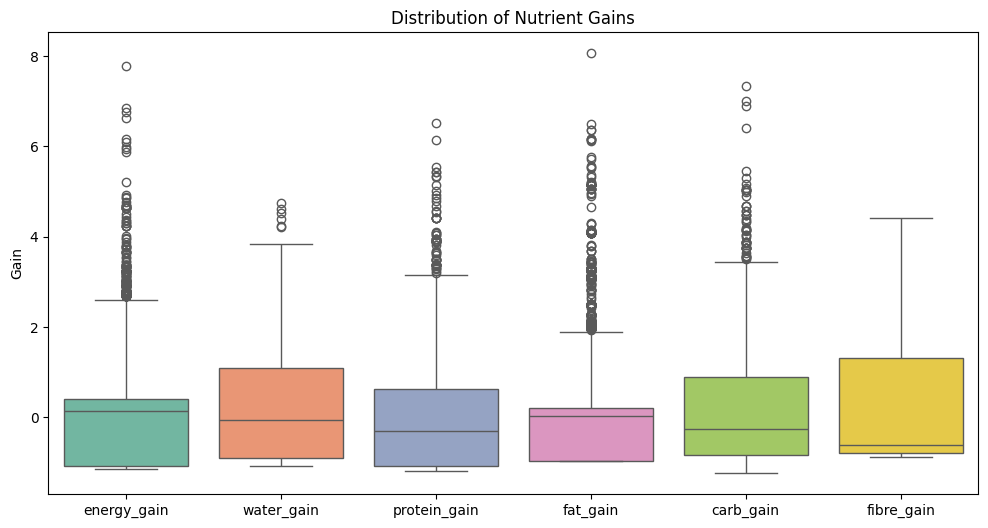

In [ ]:

# Boxplot for multiple nutrition-related columns
nutrition_columns = ['energy_gain', 'water_gain', 'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain']
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_final_sampled.query('energy_gain >0 and water_gain >0 and protein_gain >0 and fat_gain >0 and carb_gain >0 and fibre_gain>0')[nutrition_columns])

plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(normalized_data, columns=nutrition_columns), palette='Set2')
plt.title('Distribution of Nutrient Gains')
plt.ylabel('Gain')
plt.show()


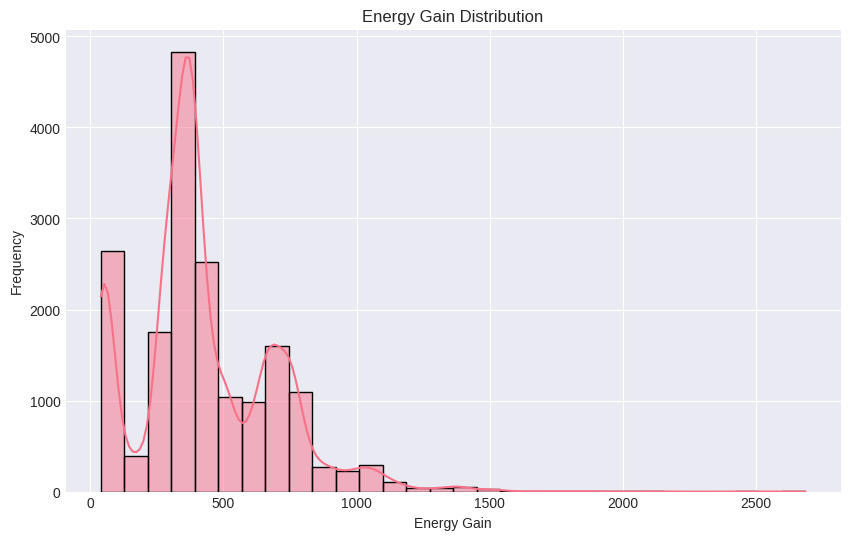

In [100]:

# Plotting a histogram for 'energy_gain'
plt.figure(figsize=(10, 6))
sns.histplot(df_final_sampled.query('energy_gain>0')['energy_gain'], kde=True, bins=30)
plt.title('Energy Gain Distribution')
plt.xlabel('Energy Gain')
plt.ylabel('Frequency')
plt.show()

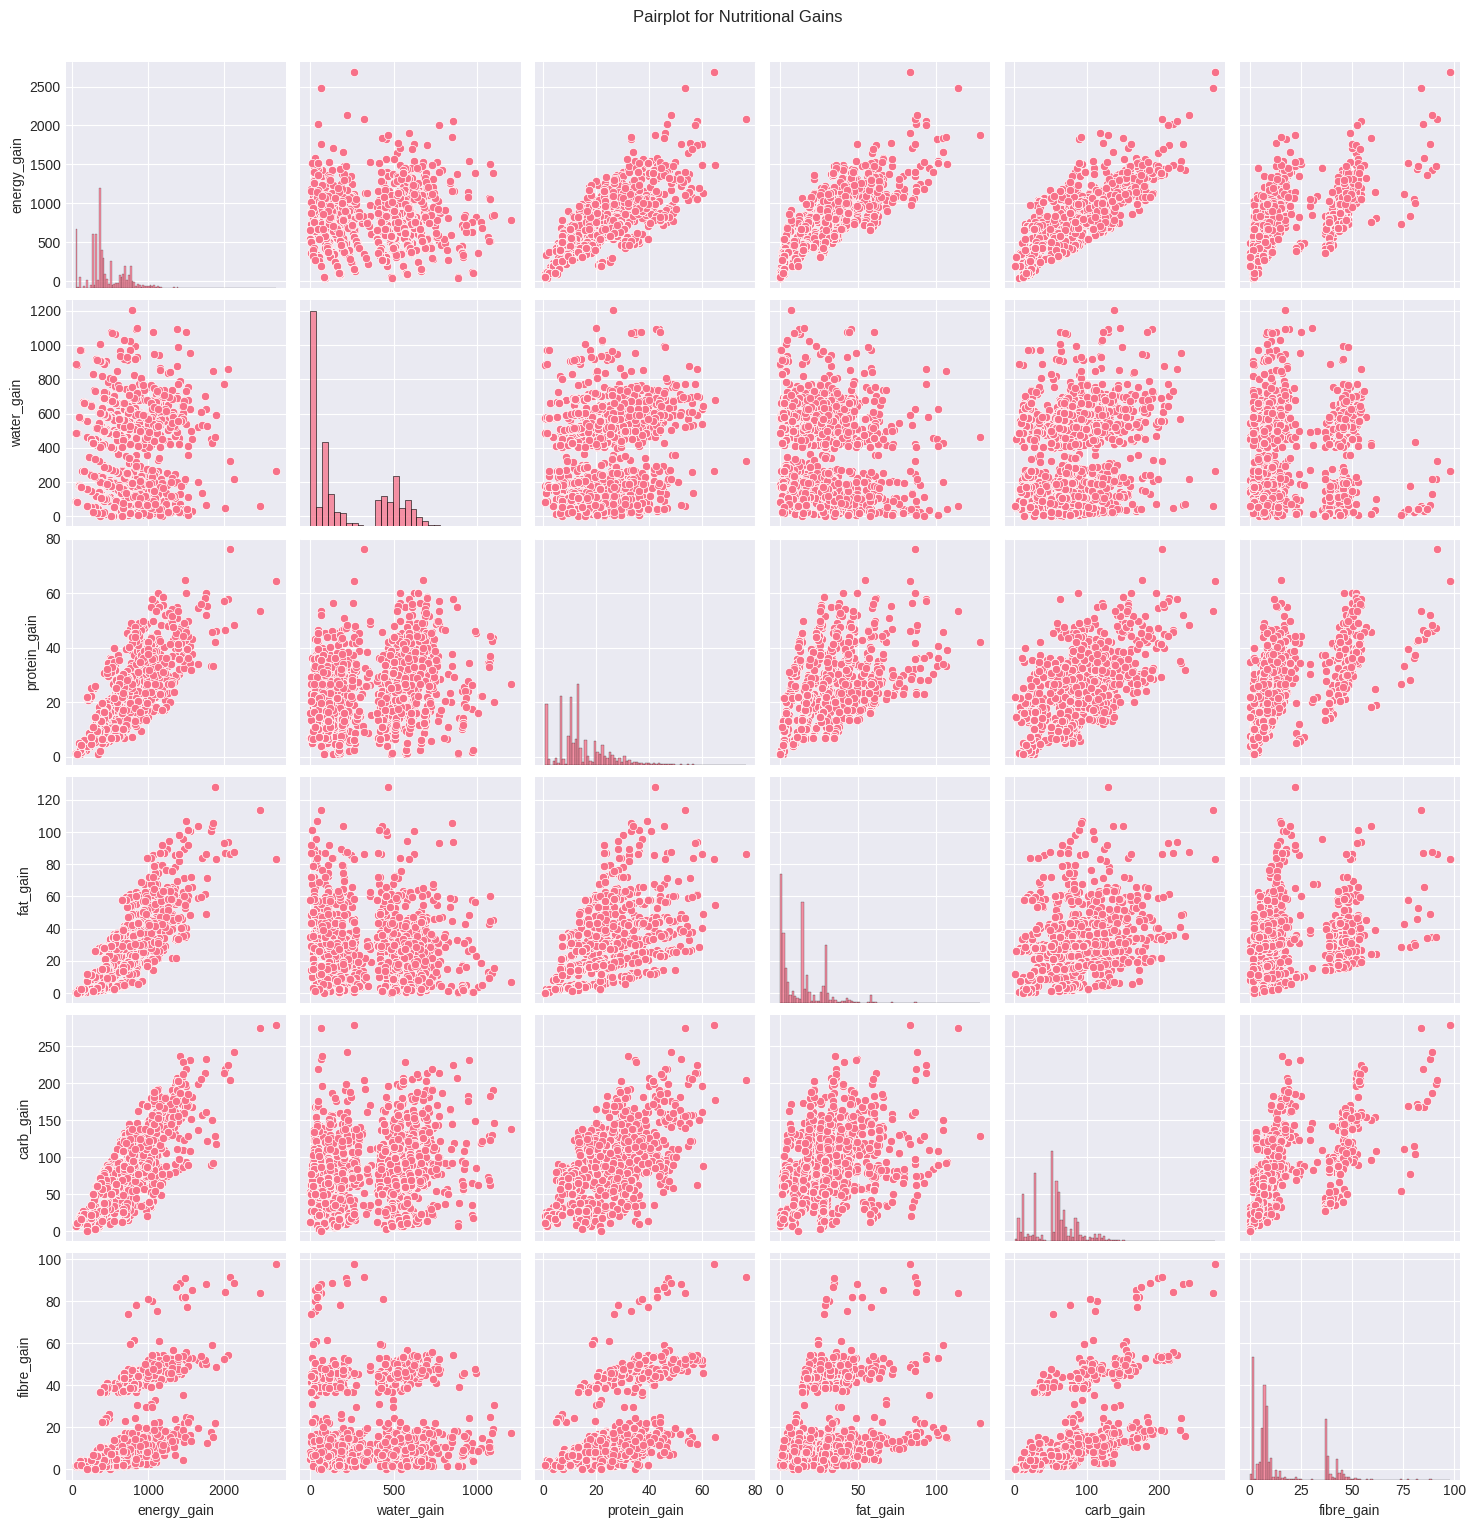

In [89]:
# Define the subset of columns to include in the pairplot
nutrition_columns = ['energy_gain', 'water_gain', 'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain']

# Filter the DataFrame based on the specified conditions
filtered_df = df_final_sampled.query('energy_gain > 0 and water_gain > 0 and protein_gain > 0 and fat_gain > 0 and carb_gain > 0 and fibre_gain > 0')

# Create the pairplot
sns.pairplot(filtered_df[nutrition_columns])
plt.suptitle('Pairplot for Nutritional Gains', y=1.02)  # Add a title with some padding
plt.show()

## Sport Activity Analysis

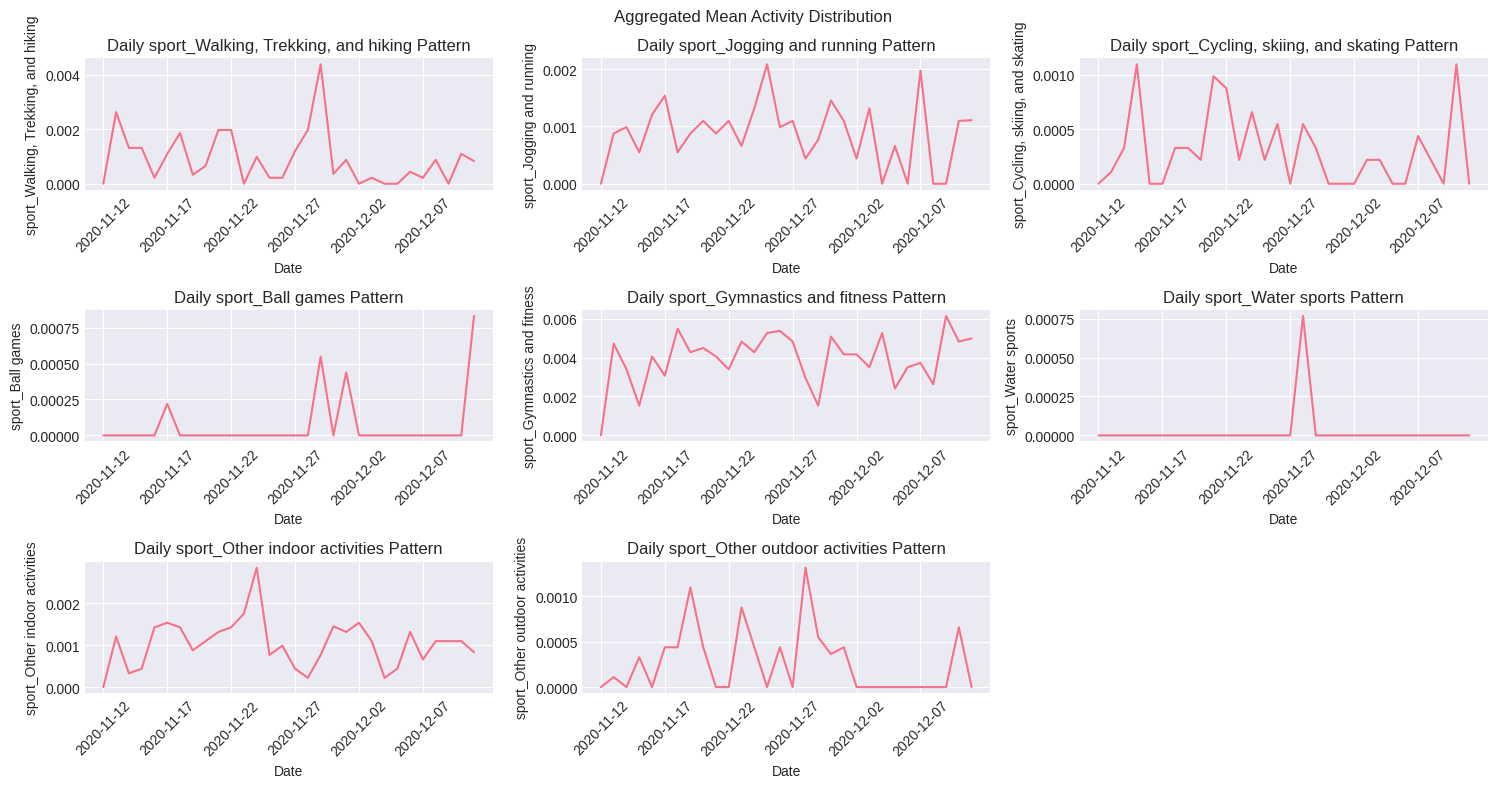

In [115]:
sport_cols = [col for col in df_final_sampled.columns if 'sport_' in col and col != 'sport_cat']
daily_nutrients = df_final_sampled.set_index('social_date')[sport_cols].resample('D').mean()

plt.figure(figsize=(15, 8))
plt.suptitle("Aggregated Mean Activity Distribution")
for i, col in enumerate(sport_cols, 1):
    plt.subplot(3, 3, i)
    plt.plot(daily_nutrients.index, daily_nutrients[col])
    plt.xticks(daily_nutrients.index[::5], rotation=45)
    plt.title(f'Daily {col} Pattern')
    plt.xlabel('Date')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

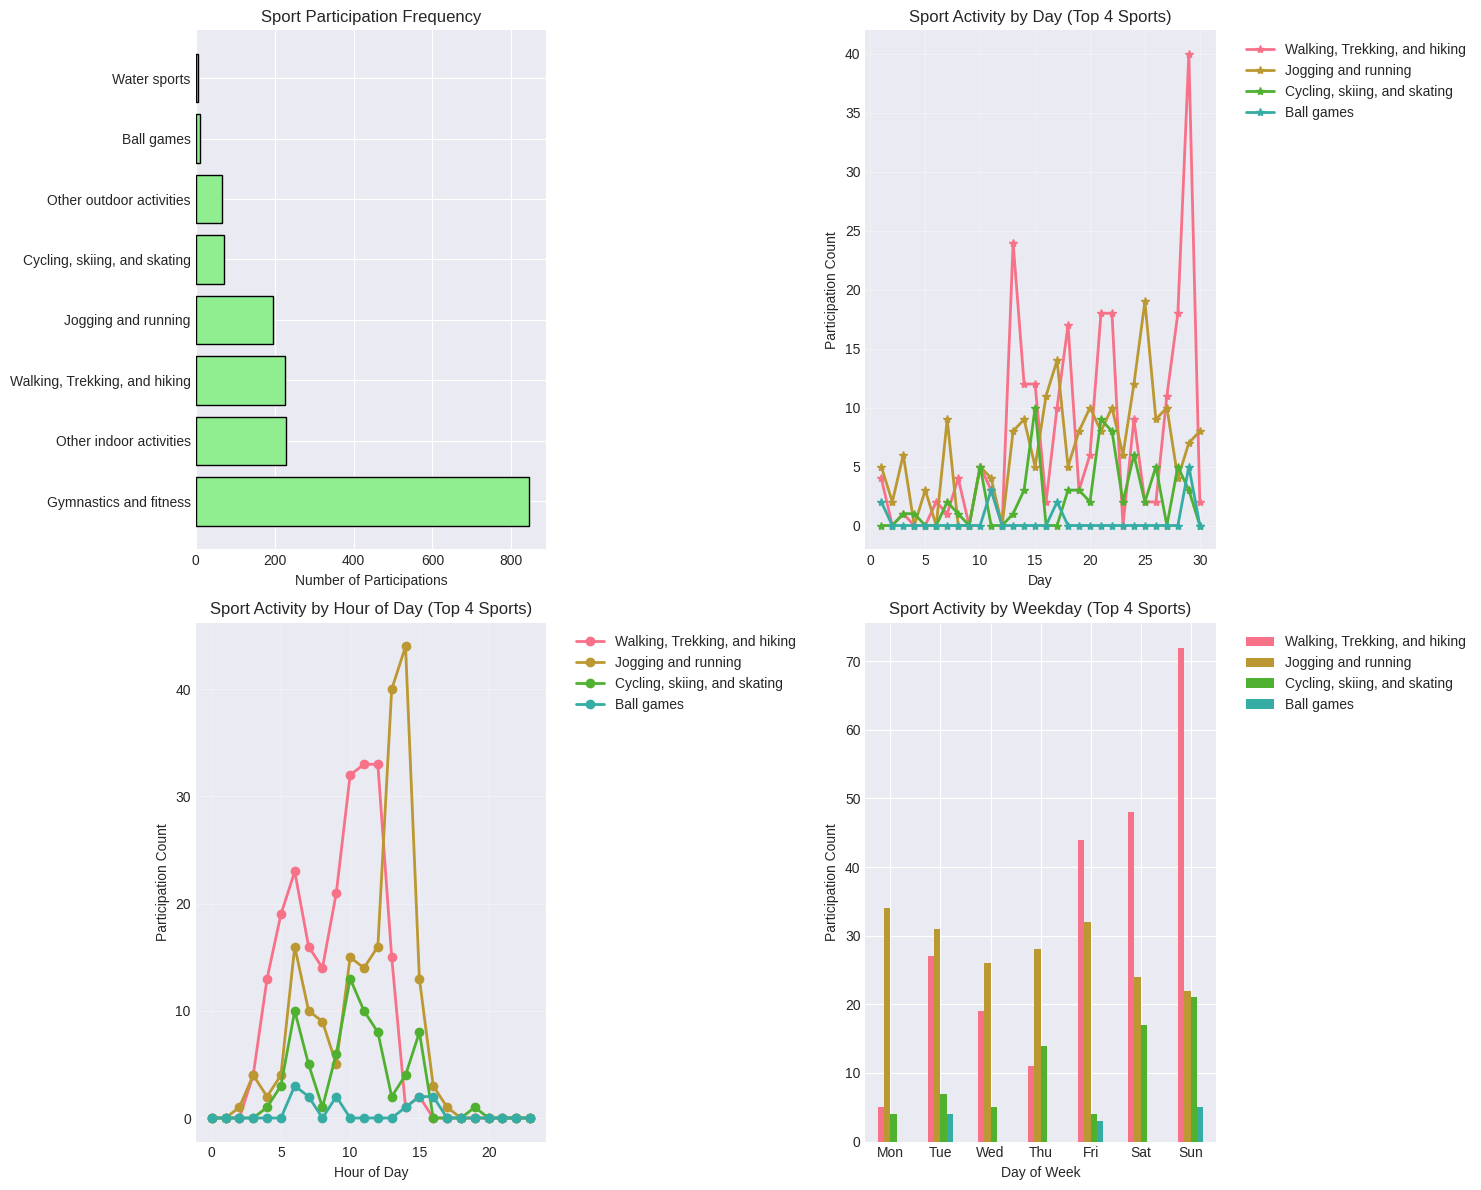


=== SPORT PARTICIPATION SUMMARY ===
                               Participants
Gymnastics and fitness                  846
Other indoor activities                 228
Walking, Trekking, and hiking           226
Jogging and running                     197
Cycling, skiing, and skating             72
Other outdoor activities                 66
Ball games                               12
Water sports                              7


In [113]:
def analyze_sport_activities(df):
    sport_columns = [col for col in df.columns if col.startswith('sport_') and col != 'sport_cat']
    
    # Calculate total participation for each sport
    sport_participation = {}
    for sport in sport_columns:
        sport_name = sport.replace('sport_', '')
        sport_participation[sport_name] = df[sport].sum()
    
    # Sort by participation
    sport_df = pd.DataFrame.from_dict(sport_participation, orient='index', columns=['Participants'])
    sport_df = sport_df.sort_values('Participants', ascending=False)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Sport participation bar chart
    axes[0, 0].barh(sport_df.index, sport_df['Participants'], color='lightgreen', edgecolor='black')
    axes[0, 0].set_xlabel('Number of Participations')
    axes[0, 0].set_title('Sport Participation Frequency')
    
    # Sport by  day
    sport_daily = pd.DataFrame()
    for sport in sport_columns[:4]:  
        sport_name = sport.replace('sport_', '')
        sport_daily[sport_name] = df.groupby('day')[sport].sum()
    
    sport_daily.plot(ax=axes[0, 1], marker='*', linewidth=2)
    axes[0, 1].set_xlabel('Day')
    axes[0, 1].set_ylabel('Participation Count')
    axes[0, 1].set_title('Sport Activity by Day (Top 4 Sports)')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)

    
    # Sport by hour of day
    sport_hourly = pd.DataFrame()
    for sport in sport_columns[:4]:  
        sport_name = sport.replace('sport_', '')
        sport_hourly[sport_name] = df.groupby('hour')[sport].sum()
    
    sport_hourly.plot(ax=axes[1, 0], marker='o', linewidth=2)
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Participation Count')
    axes[1, 0].set_title('Sport Activity by Hour of Day (Top 4 Sports)')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Sport by weekday
    sport_weekday = pd.DataFrame()
    weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for sport in sport_columns[:4]:
        sport_name = sport.replace('sport_', '')
        sport_weekday[sport_name] = df.groupby('weekday')[sport].sum()
    
    sport_weekday.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Participation Count')
    axes[1, 1].set_title('Sport Activity by Weekday (Top 4 Sports)')
    axes[1, 1].set_xticklabels(weekday_names, rotation=0)
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('eda_figures/sport_analysis.png', bbox_inches='tight')
    plt.show()
    
    return sport_df
df = df_final_sampled.copy()
df['hour'] = pd.to_datetime(df['social_date'], format='%H:%M').dt.hour
df['day'] = pd.to_datetime(df['social_date'], format='%H:%M').dt.day

df['weekday'] = pd.to_datetime(df['social_date']).dt.weekday
sport_analysis = analyze_sport_activities(df)
print("\n=== SPORT PARTICIPATION SUMMARY ===")
print(sport_analysis)